# Quarto

In [1]:
import logging
import argparse
import random
import quarto
from collections import namedtuple
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pickle

In [2]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

## An agent using fixed rules

### The random player

In [3]:
class RandomPlayer(quarto.Player):
    """Random player"""

    def __init__(self, quarto: quarto.Quarto) -> None:
        super().__init__(quarto)

    def choose_piece(self) -> int:
        return random.randint(0, 15)

    def place_piece(self) -> tuple[int, int]:
        return random.randint(0, 3), random.randint(0, 3)

### Some hardcoded strategies

We'll try to simulate some human behaviours.

### Placing criteria
The placing phase can be characterized by 11 different strategies:
- Place in the lowest row
- Place in the highest row
- Place in the middle row
- Place in the lowest column
- Place in the highest column
- Place in the middle column
- Place in the lowest coordinates
- Place in the highest coordinates
- Place in the middle coordinates
- Try to fill a row/column/diagonal
- Try not to fill a row/column/diagonal

In [5]:
def get_lowest_row(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_highest_row(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for x in reversed(range(game.BOARD_SIDE)):
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_middle_row(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for x in [1, 2, 0, 3]:
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_lowest_column(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for y in range(game.BOARD_SIDE):
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_highest_column(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for y in reversed(range(game.BOARD_SIDE)):
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_middle_column(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for y in [1, 2, 0, 3]:
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_lowest_coordinates(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    sum = game.BOARD_SIDE**2
    coordinates = None, None
    for y in range(game.BOARD_SIDE):
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1:
                if sum > x + y:
                    sum = x + y
                    coordinates = x, y
    return coordinates

def get_highest_coordinates(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    sum = -1
    coordinates = None, None
    for y in reversed(range(game.BOARD_SIDE)):
        for x in reversed(range(game.BOARD_SIDE)):
            if board[y, x] == -1:
                if sum < x + y:
                    sum = x + y
                    coordinates = x, y
    return coordinates

def get_middle_coordinates(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    first_ring = [(1, 1), (1, 2), (2, 1), (2, 2)]
    for x, y in first_ring:
        if board[y, x] == -1: return x, y
    second_ring = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 3), (2, 0), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
    for x, y in second_ring:
        if board[y, x] == -1: return x, y
    return None, None

def get_fill_coordinates(game: quarto.Quarto, action="fill") -> tuple[int, int]:
    '''action can be "fill" or "unfill"'''
    assert action == "fill" or action == "unfill"

    min_or_max = min if action == "unfill" else max
    board = game.get_board_status()
    sum_rows = {}
    sum_columns = {}
    sum_first_diagonal = 4
    sum_second_diagonal = 4
    c_row = {}
    c_column = {}
    c_first_diagonal = None, None
    c_second_diagonal = None, None
    
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1:
                if x not in sum_rows: sum_rows[x] = 4
                if y not in sum_columns: sum_columns[y] = 4
                sum_rows[x] -= 1
                c_row[x] = x, y
                sum_columns[y] -= 1
                c_column[y] = x, y
                if (x == 3 and y == 0) or (x == 2 and y == 1) or (x == 1 and y == 2) or (x == 0 and y == 3):
                    sum_first_diagonal -= 1
                    c_first_diagonal = x, y
                elif x == y:
                    sum_second_diagonal -= 1
                    c_second_diagonal = x, y
    max_row = min_or_max(sum_rows, key=sum_rows.get) if len(sum_rows) != 0 else None
    max_column = min_or_max(sum_columns, key=sum_columns.get) if len(sum_columns) != 0 else None
    dictionary = {}
    if max_row != None: dictionary[0] = sum_rows[max_row]
    if max_column != None: dictionary[1] = sum_columns[max_column]
    if sum_first_diagonal != 4: dictionary[2] = sum_first_diagonal
    if sum_second_diagonal != 4: dictionary[3] = sum_second_diagonal

    max_ = min_or_max(dictionary, key=dictionary.get) if len(dictionary) != 0 else None
    if max_ == 0: return c_row[max_row]
    elif max_ == 1: return c_column[max_column]
    elif max_ == 2: return c_first_diagonal
    elif max_ == 3: return c_second_diagonal
    else: 
        return None, None

### Choosing criteria
The choosing phase can be characterized by 4 different strategies:
- Choose a piece with the most uncommon properties
- Choose a piece with the most common properties
- Choose a piece with similar properties of the last chosen piece
- Choose a piece with different properties of the last chosen piece

In [6]:
def get_most_common_piece(game: quarto.Quarto, action="common") -> int:
    '''action can be "common" or "uncommon"'''
    assert action == "common" or action == "uncommon"

    high = 0
    coloured = 0
    solid = 0
    square = 0
    pieces = list(range(16))
    board = game.get_board_status()
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            piece = board[y, x]
            if piece != -1:
                pieces.remove(piece)
                if piece & 1 == 1: square += 1
                if piece & 2 == 2: solid += 1
                if piece & 4 == 4: coloured += 1
                if piece & 8 == 8: high += 1
    properties = {}
    if high != 8: properties[8] = high
    if coloured != 8: properties[4] = coloured
    if solid != 8: properties[2] = solid
    if square != 8: properties[1] = square
    sorted_keys = sorted(properties, key=properties.get, reverse=(action=="common"))
    for piece in pieces:
        try:
            if piece & sorted_keys[0] == sorted_keys[0]:
                return piece
        except:
            # sorted_keys can have 0 length, this is due to the fact that piece 0 has False to all the properties
            # This happens only if 0 is the last piece remaining
            return piece
    return pieces[0] if len(pieces) != 0 else None

def get_most_similar_piece(game: quarto.Quarto, action="similar"):
    '''action can be "similar" or "different"'''
    assert action == "similar" or action == "different"

    board = game.get_board_status()
    last_piece = game.get_selected_piece()
    pieces = list(range(16))
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            piece = board[y, x]
            if piece != -1:
                pieces.remove(piece)
    best = None
    similarity = 0 if action == "similar" else game.BOARD_SIDE**2
    for piece in pieces:
        current = 1
        if piece & 1 == last_piece & 1: current += 1
        if piece & 2 == last_piece & 2: current += 1
        if piece & 4 == last_piece & 4: current += 1
        if piece & 8 == last_piece & 8: current += 1
        if action == "similar" and current > similarity:
            best = piece
            similarity = current
        if action == "different" and current < similarity:
            best = piece
            similarity = current
    return best

### The hardcoded player

In [7]:
class HardcodedPlayer(quarto.Player):
    """Hardcoded player"""

    def __init__(self, quarto: quarto.Quarto, choose_strategy, place_strategy) -> None:
        super().__init__(quarto)
        self.choose_strategy = choose_strategy[0]
        self.choose_action = choose_strategy[1]
        self.place_strategy = place_strategy[0]
        self.place_action = place_strategy[1]

    def choose_piece(self) -> int:
        return self.choose_strategy(self.get_game(), self.choose_action)

    def place_piece(self) -> tuple[int, int]:
        return self.place_strategy(self.get_game(), self.place_action)

### The tournament

In [7]:
choose_strategies = [get_most_common_piece, get_most_common_piece, get_most_similar_piece, get_most_similar_piece]
choose_actions = ["common", "uncommon", "similar", "different"]
place_strategies = [get_lowest_row, get_highest_row, get_middle_row, get_lowest_column, get_highest_column, get_middle_column, get_lowest_coordinates, get_highest_coordinates, get_middle_coordinates, get_fill_coordinates, get_fill_coordinates]
place_actions = [None, None, None, None, None, None, None, None, None, "fill", "unfill"]

In [8]:
leaderboard = {}
game = quarto.Quarto()
random_player = RandomPlayer(game)
for choose_index, choose_strategy in enumerate(choose_strategies):
    for place_index, place_strategy in enumerate(place_strategies):
        NUM_MATCHES = 200
        won = 0
        hardcoded_player = HardcodedPlayer(
            game,
            [choose_strategy, choose_actions[choose_index]],
            [place_strategy, place_actions[place_index]]
        )
        for match in range(NUM_MATCHES):
            game.reset()
            if match % 2 == 0: game.set_players((hardcoded_player, random_player))
            else: game.set_players((random_player, hardcoded_player))
            if game.run() == match % 2: won += 1
        leaderboard[
            f"- Choose Strategy: {choose_strategy.__name__}, {choose_actions[choose_index]}\n- Place Strategy: {place_strategy.__name__}, {place_actions[place_index]}"
        ] = won/NUM_MATCHES
for index, participant in enumerate(sorted(leaderboard, key=leaderboard.get, reverse=True)):
    logging.info(f"Participant n° {index+1}")
    logging.info(participant)
    logging.info(f"- Win ratio: {leaderboard[participant]}\n")

Participant n° 1
- Choose Strategy: get_most_similar_piece, different
- Place Strategy: get_fill_coordinates, fill
- Win ratio: 0.89

Participant n° 2
- Choose Strategy: get_most_similar_piece, similar
- Place Strategy: get_fill_coordinates, fill
- Win ratio: 0.775

Participant n° 3
- Choose Strategy: get_most_common_piece, common
- Place Strategy: get_fill_coordinates, fill
- Win ratio: 0.77

Participant n° 4
- Choose Strategy: get_most_common_piece, uncommon
- Place Strategy: get_fill_coordinates, fill
- Win ratio: 0.755

Participant n° 5
- Choose Strategy: get_most_similar_piece, different
- Place Strategy: get_middle_column, None
- Win ratio: 0.74

Participant n° 6
- Choose Strategy: get_most_similar_piece, different
- Place Strategy: get_lower_column, None
- Win ratio: 0.735

Participant n° 7
- Choose Strategy: get_most_similar_piece, different
- Place Strategy: get_higher_row, None
- Win ratio: 0.73

Participant n° 8
- Choose Strategy: get_most_similar_piece, different
- Place St

## An agent using evolved rules

### Individual
An individual is formed by two lists:
- The first one contains four numbers that refer to the choosing phase.
- The second one contains four numbers that refer to the placing phase.

Each number represents the index of the strategy to be used in one of the phases of the game, knowing that the game has been divided in four phases:
- Less than a quarter of pieces placed on the board
- Less than a half of pieces placed on the board
- Less than three-quarters of pieces placed on the board
- More than three-quarters of pieces placed on the board

In [9]:
Individual = namedtuple("Individual", ["genome", "fitness"])

### Evolved strategy
It is a method that can be used both in the choosing and in the placing phase.<br>
It takes as argument one of the two lists of the individual, then generate a random number, and uses it to return an appropriate result (coordinates or piece index) based on the chosen strategy.

In [10]:
def get_evolved_strategy(game: quarto.Quarto, half_individual, action="place"):
    '''action can be "place" or "choose"'''
    # half_individual is made of probabilities in [0.0, 1.0] (with 1 decimal digit)
    assert action == "place" or action == "choose"
    assert len(half_individual) == 4

    if action == "choose":
        strategies = [get_most_common_piece, get_most_common_piece, get_most_similar_piece, get_most_similar_piece]
        actions = ["common", "uncommon", "similar", "different"]
    else:
        strategies = [get_lowest_row, get_highest_row, get_middle_row, get_lowest_column, get_highest_column, get_middle_column, get_lowest_coordinates, get_highest_coordinates, get_middle_coordinates, get_fill_coordinates, get_fill_coordinates]
        actions = [None, None, None, None, None, None, None, None, None, "fill", "unfill"]
    
    board = game.get_board_status()
    pieces_num = 0
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            if board[y, x] != -1:
                pieces_num += 1
    
    if pieces_num < game.BOARD_SIDE / 4: return strategies[half_individual[0]](game, action=actions[half_individual[0]])
    elif pieces_num < game.BOARD_SIDE / 2: return strategies[half_individual[1]](game, action=actions[half_individual[1]])
    elif pieces_num < game.BOARD_SIDE * 3 / 4: return strategies[half_individual[2]](game, action=actions[half_individual[2]])
    else: return strategies[half_individual[3]](game, action=actions[half_individual[3]])

### The evolved player

In [11]:
class EvolvedPlayer(quarto.Player):
    """Evolved player"""

    def __init__(self, quarto: quarto.Quarto, individual) -> None:
        super().__init__(quarto)
        self.choose_individual = individual[0]
        self.place_individual = individual[1]

    def choose_piece(self) -> int:
        return get_evolved_strategy(self.get_game(), self.choose_individual, "choose")

    def place_piece(self) -> tuple[int, int]:
        return get_evolved_strategy(self.get_game(), self.place_individual, "place")

### Cross-over
Given two individual, merge them by taking a random $num$ of numbers of the first one and `NUM_ROWS - num` numbers of the second one, twice (for both the lists in the individuals).

In [12]:
# returns individuals with max fitness (the fittest) but still random
def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)

def cross_over(g1, g2):
    cut = random.randint(0, 3)
    return [
        g1[0][:cut] + g2[0][cut:],
        g1[1][:cut] + g2[1][cut:]
    ]

### Mutation
Replace a random number of the individual with another random number, twice (for both the lists of the individuals).

In [13]:
def mutation(g):
    point = random.randint(0, 3)
    new_choose = random.randint(0, 3)
    new_place = random.randint(0, 10)
    return [
        g[0][:point] + ([new_choose]) + g[0][point + 1 :],
        g[1][:point] + ([new_place]) + g[1][point + 1 :]
    ]

### Fitness
The fitness is the winning ratio of the individual against the random agent in a fixed number of matches.<br>
The evolved player makes the first move in half of the games.

In [14]:
def fitness(individual, num_matches=200):
    won = 0
    game = quarto.Quarto()
    evolved_player = EvolvedPlayer(game, individual)
    random_player = RandomPlayer(game)
    for match in range(num_matches):
        game.reset()
        if match % 2 == 0: game.set_players((evolved_player, random_player))
        else: game.set_players((random_player, evolved_player))
        if game.run() == match % 2: won += 1
    return won/num_matches

### Initial Population

In [15]:
POPULATION_SIZE = 10
OFFSPRING_SIZE = 3

NUM_GENERATIONS = 200
FITNESS_PRECISION = 400

In [16]:
population = list()
for index in range(POPULATION_SIZE):
    genome = [
        [random.randint(0, 3) for _ in range(4)],
        [random.randint(0, 10) for _ in range(4)]
    ]
    population.append(Individual(genome, fitness(genome, FITNESS_PRECISION)))

logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}")

init: pop_size=10; max=0.8725


### Evolution Algorithm

In [17]:
fitness_log = [(0, i.fitness) for i in population]

mutation_rate = 0.3
for g in range(NUM_GENERATIONS):
    #if g % 50 == 49: mutation_rate -= 0.5
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random.random() < mutation_rate:
            p = tournament(population)
            o = mutation(p.genome)
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = cross_over(p1.genome, p2.genome)
        f = fitness(o, num_matches=FITNESS_PRECISION)
        fitness_log.append((g + 1, f))
        offspring.append(Individual(o, f))
    for goff in offspring:
        if goff not in population:
            population.append(goff)
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]

best_individual = max(population, key=lambda i: i.fitness)

logging.info(f"Number of generations: {NUM_GENERATIONS}")
logging.info(f"Population size: {POPULATION_SIZE}")
logging.info(f"Offspring size: {OFFSPRING_SIZE}\n")

logging.info(f"Best individual")
logging.info(f" Choose: {best_individual.genome[0]}")
logging.info(f" Place: {best_individual.genome[1]}")
logging.info(f" Fitness: {best_individual.fitness}")

Number of generations: 200
Population size: 10
Offspring size: 3

Best individual
 Choose: [2, 3, 2, 3]
 Place: [6, 8, 5, 9]
 Fitness: 0.9


### Performance Evaluation

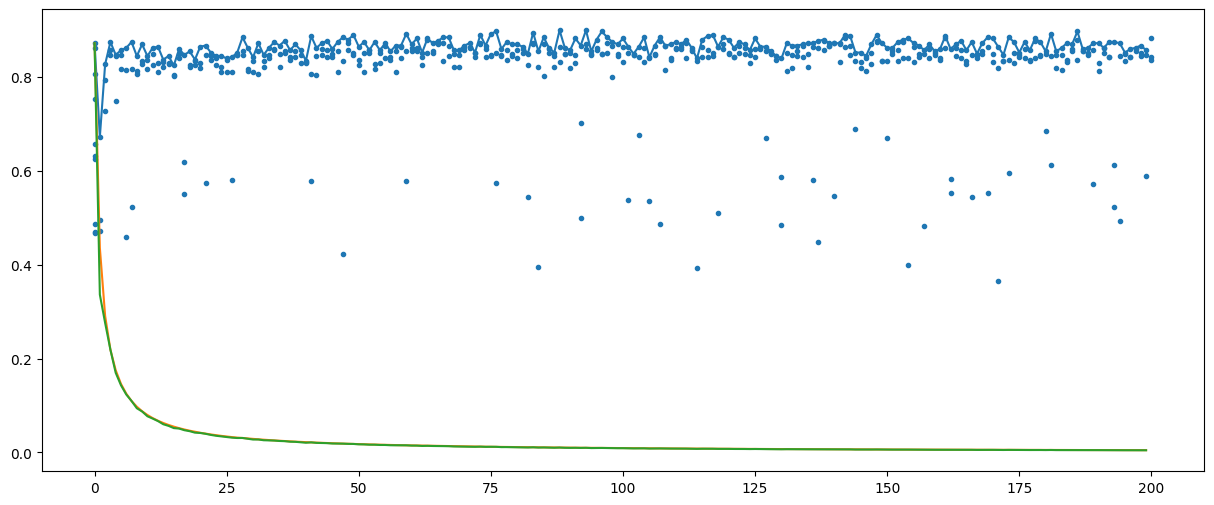

In [18]:
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])

### Further evaluations

A more accurate fitness

In [19]:
fitness(best_individual.genome, num_matches=10000)

0.8637

A tournament against all the hardcoded strategies

In [20]:
won = 0
tot_matches = 0
NUM_MATCHES = 2000
game = quarto.Quarto()
evolved_player = EvolvedPlayer(game, best_individual.genome)
for choose_index, choose_strategy in enumerate(choose_strategies):
    for place_index, place_strategy in enumerate(place_strategies):
        hardcoded_player = HardcodedPlayer(
            game,
            [choose_strategy, choose_actions[choose_index]],
            [place_strategy, place_actions[place_index]]
        )
        for match in range(NUM_MATCHES):
            tot_matches += 1
            game.reset()
            if match % 2 == 0: game.set_players((evolved_player, hardcoded_player))
            else: game.set_players((hardcoded_player, evolved_player))

            if game.run() == match % 2: won += 1

random_player = RandomPlayer(game)
for match in range(NUM_MATCHES):
    tot_matches += 1
    game.reset()
    if match % 2 == 0: game.set_players((evolved_player, random_player))
    else: game.set_players((random_player, evolved_player))

    if game.run() == match % 2: won += 1

logging.info(f"Win ratio: {won/tot_matches}")

Win ratio: 0.7522777777777778


### Match

In [21]:
game = quarto.Quarto()
game.set_players((EvolvedPlayer(game, best_individual.genome), RandomPlayer(game)))
winner = game.run()
logging.warning(f"Winner: player {winner}")

Winner: player 0


## An agent using minmax

Minmax is a simple algorithm that simulates all the possible moves and choose the best one.

The function can be called in four modes:
- Mode 0: the 1st player is placing a piece
- Mode 1: the 1st player is choosing a piece
- Mode 2: the 2nd player is placing a piece
- Mode 3: the 2bd player is choosing a piece

The 1st player is trying to minimize the reward, while the 2nd player s trying to maximize it.

The alpha-beta pruning strategy has been implemented, in order to decrease the number of calculations.

In [12]:
def get_available_vectors(board, side):
    available_coordinates = list()
    available_pieces = list(range(16))
    for x in range(side):
        for y in range(side):
            piece = board[y, x]
            if piece == -1:
                available_coordinates.append((x, y))
            else:
                available_pieces.remove(piece)
    return available_coordinates, available_pieces

In [9]:
def board_to_tuple(board):
    return tuple(tuple(row) for row in board)

In [100]:
cache = {}
cache['hit'] = 0
def minmax(game: quarto.Quarto, alpha = -1, beta = 1, mode = 0, depth = 0, max_depth = None):
    # mode:
    # 0 - placing - 1st player
    # 1 - choosing - 1st player
    # 2 - placing - 2nd player
    # 3 - choosing - 2nd player
    if max_depth != None and depth > max_depth or game.check_finished():
        # return None, random.choice((-1, 1))
        return None, 0 if game.check_finished() else 1 if mode < 2 else -1
    if game.check_winner() != -1:
        return None, -1 if mode < 2 else 1
    
    board = game.get_board_status()
    key_ = f"{board_to_tuple(board)} {mode}"
    if key_ in cache.keys():
        cache['hit'] += 1
        return cache[key_]
    
    evaluations = list()

    available_coordinates, available_pieces = get_available_vectors(board, game.BOARD_SIDE)
    
    for ply in available_coordinates if mode % 2 == 0 else available_pieces:
        board = deepcopy(game)
        if mode % 2 == 0: # placing phase
            board.place(*ply)
        else: # choosing phase
            board.select(ply)
        _, val = minmax(board, alpha=alpha, beta=beta, mode=(mode+1)%4, depth=depth+1, max_depth=max_depth)
        evaluations.append((ply, val))
        if mode < 2: # 1st player -> minimizing
            beta = min(beta, val)
        else: #2nd player -> maximizing
            alpha = max(alpha, val)
        if beta <= alpha:
            break
    if mode < 2:
        val = min(evaluations, key=lambda k: k[1])
    else:
        val = max(evaluations, key=lambda k: k[1])
    cache[key_] = val
    return val

In [101]:
game = quarto.Quarto()
logging.info(minmax(game, mode=1, max_depth=10))
cache={}
cache['hit'] = 0

(0, 1)


### The Minmax Agent

In [49]:
class MinmaxPlayer(quarto.Player):
    """Minmax player"""

    def __init__(self, quarto: quarto.Quarto, max_depth=None) -> None:
        super().__init__(quarto)
        self.max_depth = max_depth

    def choose_piece(self) -> int:
        return minmax(self.get_game(), mode=1, max_depth=self.max_depth)[0]

    def place_piece(self) -> tuple[int, int]:
        return minmax(self.get_game(), mode=0, max_depth=self.max_depth)[0]

#### Match

In [61]:
game = quarto.Quarto()
minmax_player = MinmaxPlayer(game, 10)
random_player = RandomPlayer(game)
game.set_players((minmax_player, random_player))

In [63]:
logging.info(f"Cache length: {len(cache) - 1}")
game.reset()
winner = game.run()
logging.info(f"Winner: player {winner}")
logging.info(f"Cache hit: {cache['hit']}")
cache['hit'] = 0
logging.info(f"Cache length: {len(cache) - 1}")

Cache length: 8941
Winner: player 0
Cache hit: 3293
Cache length: 10184


In [66]:
cache={}
cache['hit'] = 0

#### The evaluation

In [7]:
def evaluate(game: quarto.Quarto, first_player: quarto.Player, second_player: quarto.Player, num_matches=1000):
    won = 0
    for match in range(num_matches):
        game.reset()
        winner = game.run()
        if winner == 0:
            won += 1
        #     logging.info(f"Game {match+1} won")
        # elif winner == -1:
        #     logging.info(f"Game {match+1} drew")
        # else:
        #     logging.info(f"Game {match+1} lost")
    logging.info(f"Win ratio: {won/num_matches}")

In [69]:
logging.info(f"Cache length: {len(cache) - 1}")
evaluate(game, minmax_player, random_player, num_matches=10)
logging.info(f"Cache hit: {cache['hit']}")
cache['hit'] = 0
logging.info(f"Cache length: {len(cache) - 1}")

Cache length: 40273
Game 1 won
Game 2 won
Game 3 won
Game 4 lost
Game 5 won
Game 6 won
Game 7 won
Game 8 lost
Game 9 won
Game 10 won
Win ratio: 0.8
Cache hit: 48393
Cache length: 58966


### The Random-Minmax Agent

In [21]:
class RandomMinmaxPlayer(quarto.Player):
    """Random-Minmax player"""

    def __init__(self, quarto: quarto.Quarto, max_depth=None) -> None:
        super().__init__(quarto)
        self.max_depth = max_depth

    def choose_piece(self) -> int:
        board = self.get_game().get_board_status()
        piece_count = len([element for row in board for element in row if element == -1])
        if piece_count > 12:
            while True:
                piece = random.randint(0, 15)
                if piece not in board: break
            return piece
        return minmax(self.get_game(), mode=1, max_depth=self.max_depth)[0]

    def place_piece(self) -> tuple[int, int]:
        board = self.get_game().get_board_status()
        piece_count = len([element for row in board for element in row if element == -1])
        if piece_count > 12:
            while True:
                x, y = random.randint(0, 3), random.randint(0, 3)
                if board[y, x] == -1: break
            return x, y
        return minmax(self.get_game(), mode=0, max_depth=self.max_depth)[0]

#### Match

In [96]:
cache={}
cache['hit'] = 0

In [94]:
game = quarto.Quarto()
random_minmax_player = RandomMinmaxPlayer(game, 12)
random_player = RandomPlayer(game)
game.set_players((random_minmax_player, random_player))

In [95]:
logging.info(f"Cache length: {len(cache) - 1}")
game.reset()
winner = game.run()
logging.info(f"Winner: player {winner}")
logging.info(f"Cache hit: {cache['hit']}")
cache['hit'] = 0
logging.info(f"Cache length: {len(cache) - 1}")

Cache length: 0
Winner: player 0
Cache hit: 10139
Cache length: 4506


#### The evaluation

In [98]:
logging.info(f"Cache length: {len(cache) - 1}")
evaluate(game, random_minmax_player, random_player, num_matches=10)
logging.info(f"Cache hit: {cache['hit']}")
cache['hit'] = 0
logging.info(f"Cache length: {len(cache) - 1}")

Cache length: 50946
Game 1 won
Game 2 won
Game 3 won
Game 4 won
Game 5 won
Game 6 won
Game 7 won
Game 8 won
Game 9 won
Game 10 won
Win ratio: 1.0
Cache hit: 144647
Cache length: 113842


## An agent using reinforcement learning

### Pickle

In [4]:
def dump_pickle(G_choose, G_place):
    pickle_out = open("G_choose.pickle","wb")
    pickle.dump(G_choose, pickle_out)
    pickle_out.close()
    pickle_out = open("G_place.pickle","wb")
    pickle.dump(G_place, pickle_out)
    pickle_out.close()


def open_pickle():
    try:
        pickle_in = open("G_choose.pickle","rb")
        G_choose = pickle.load(pickle_in)
        pickle_in = open("G_place.pickle","rb")
        G_place = pickle.load(pickle_in)
    except:
        G_choose = {}
        G_place = {}
        dump_pickle(G_choose, G_place)
    #logging.info(len(G_choose))
    #logging.info(len(G_place))
    return G_choose, G_place

In [20]:
def rl_run(game: quarto.Quarto, players) -> int:
    winner = -1
    current_player = 0
    while winner < 0 and not game.check_finished():
        piece_ok = False
        while not piece_ok:
            piece_ok = game.select(players[current_player].choose_piece())
        piece_ok = False

        current_player = 1 - current_player

        while not piece_ok:
            piece_ok = game.place(*players[current_player].place_piece())

        # assume that player 0 is RLPlayer
        reward = players[0].get_reward()
        if current_player == 0:
            # update after placing a piece
            players[0].update_state_history_place(board_to_tuple(game.get_board_status()), reward)
        else:
            # update after choosing a piece
            players[0].update_state_history_choose(board_to_tuple(game.get_board_status()), reward)
        
        winner = current_player if game.check_winner() != -1 else -1
    
    return winner

In [35]:
class RLPlayer(quarto.Player):
    """Reinforcement learning player"""

    def __init__(self, quarto: quarto.Quarto, alpha=0.15, random_factor=0.1) -> None:
        super().__init__(quarto)
        board = quarto.get_board_status()
        self.state_history_choose = [(board_to_tuple(board), 0)]  # state, reward
        self.state_history_place = [(board_to_tuple(board), 0)]
        self.alpha = alpha
        self.random_factor = random_factor
        self.G_choose = {}
        self.G_place = {}

    def choose_piece(self) -> int:
        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        board = self.get_game().get_board_status()
        available_coordinates, available_pieces = get_available_vectors(board, self.get_game().BOARD_SIDE)
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(available_pieces)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for piece in available_pieces:
                for x, y in available_coordinates:
                    new_board = deepcopy(board)
                    new_board[y, x] = piece
                    new_state = board_to_tuple(new_board)

                    if new_state not in self.G_choose.keys():
                        self.G_choose[new_state] = np.random.uniform(low=1.0, high=0.1)

                    if self.G_choose[new_state] >= maxG:
                        next_move = piece
                        maxG = self.G_choose[new_state]

        return next_move

    def place_piece(self) -> tuple[int, int]:
        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        board = self.get_game().get_board_status()
        available_coordinates, _ = get_available_vectors(board, self.get_game().BOARD_SIDE)
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(available_coordinates)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for x, y in available_coordinates:
                new_board = deepcopy(board)
                new_board[y, x] = self.get_game().get_selected_piece()
                new_state = board_to_tuple(new_board)

                if new_state not in self.G_place.keys():
                    self.G_place[new_state] = np.random.uniform(low=1.0, high=0.1)

                if self.G_place[new_state] >= maxG:
                    next_move = (x, y)
                    maxG = self.G_place[new_state]

        return next_move
    
    def update_state_history_choose(self, board, reward):
        self.state_history_choose.append((board, reward))

    def update_state_history_place(self, board, reward):
        self.state_history_place.append((board, reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history_choose):
            if prev not in self.G_choose.keys():
                self.G_choose[prev] = np.random.uniform(low=1.0, high=0.1)
            self.G_choose[prev] = self.G_choose[prev] + self.alpha * (target - self.G_choose[prev])
            target += reward
        
        target = 0
        for prev, reward in reversed(self.state_history_place):
            if prev not in self.G_place.keys():
                self.G_place[prev] = np.random.uniform(low=1.0, high=0.1)
            self.G_place[prev] = self.G_place[prev] + self.alpha * (target - self.G_place[prev])
            target += reward

        self.state_history_choose = []
        self.state_history_place = []

        self.random_factor -= 10e-5  # decrease random factor each episode of play
    
    def train(self, opponent_class, num_matches=10000, saveGs=False):
        opponent_player = opponent_class(self.get_game())
        game.set_players((self, opponent_player))
        rateHistory = []
        indices = []
        won = 0
        if saveGs:
            self.G_choose, self.G_place = open_pickle()
        logging.info(f"G_place: {len(self.G_place)}\nG_choose: {len(self.G_choose)}")

        for match in range(num_matches):
            self.get_game().reset()

            if rl_run(self.get_game(), (self, opponent_player)) == 0:
                won += 1
            self.learn()
            
            if match % 100 == 99:
                win_ratio = won / 100
                rateHistory.append(win_ratio)
                indices.append(match)
                won = 0
                if match % 1000 == 999: logging.info(f"Match n° {match+1} - Win ratio: {win_ratio}")
        
        logging.info(f"G_place: {len(self.G_place)}\nG_choose: {len(self.G_choose)}")
        
        # save the Gs on file
        if saveGs:
            dump_pickle(self.G_choose, self.G_place)
            self.G_choose = {}
            self.G_place = {}

        plt.semilogy(indices, rateHistory, "b")
        plt.show()
    
    def get_reward(self):
        """Get a reward of -1 if the opponent win, 1 if I win, 0 otherwise"""
        winner = self.get_game().check_winner()
        return -1 if winner == 1 else 1 if winner == 0 else 0

### Reinforcement learning against random strategy

#### First evaluation

In [36]:
game = quarto.Quarto()
rl_player = RLPlayer(game)
random_player = RandomPlayer(game)
game.set_players((rl_player, random_player))

In [37]:
evaluate(game, rl_player, random_player, num_matches=100)

Win ratio: 0.49


#### Training

G_place: 5127
G_choose: 48337
Match n° 1000 - Win ratio: 0.51
G_place: 54854
G_choose: 514966


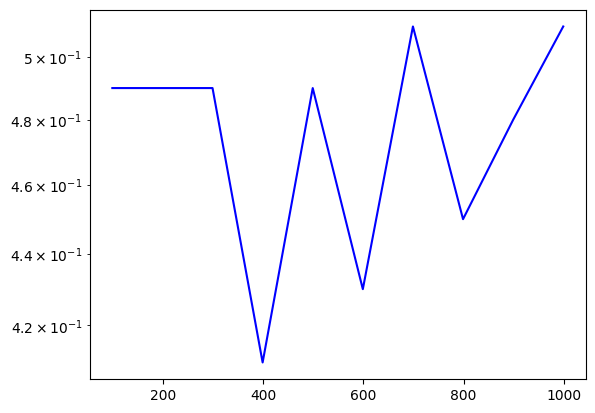

In [38]:
rl_player.train(RandomPlayer, num_matches=1000)

#### Second evaluation

In [39]:
evaluate(game, rl_player, RandomPlayer(game))

Win ratio: 0.507


### G length

| Train n° | G_place | G_choose | Time    | Win ratio |
| :------: | :-----: | :------: | :-----: | :-------: |
| 0        | 0       | 0        | -       | -         |
| 1        | 50951   | 480879   | 13s     | 0.46      |
| 2        | 99623   | 946438   | 13s     | 0.49      |
| 3        | 145333  | 1384110  | 16s     | 0.49      |
| 4        | 189238  | 1804848  | 15s     | 0.47      |
| 5        | 232551  | 2213670  | 14s     | 0.43      |
| 6        | 274858  | 2604325  | 14s     | 0.52      |
| 7        | 316579  | 2988546  | 15s     | 0.40      |
| 8        | 358542  | 3370745  | 16s     | 0.44      |
| 9        | 400620  | 3748392  | 17s     | 0.53      |
| 10       | 441668  | 4116272  | 24s     | 0.56      |
| 11       | 482988  | 4480636  | 24s     | 0.52      |
| 12       | 524043  | 4844538  | 21s     | 0.49      |
| 13       | 565350  | 5209891  | 36s     | 0.44      |
| 14       | 606903  | 5566562  | 41s     | 0.55      |
| 15       | 648557  | 5916521  | 57s     | 0.48      |
| 16       | 689831  | 6264341  | 2m 32s  | 0.49      |
| 17       | 731141  | 6617331  | 1m 25s  | 0.51      |
| 18       | 772615  | 6963659  | 2m 1s   | 0.52      |
| 19       | 814104  | 7314337  | 3m 31s  | 0.52      |
| 20       | 855315  | 7662992  | 2m 29s  | 0.53      |
| 21       | 896494  | 8014891  | 3m 17s  | 0.48      |
| 22       | 937698  | 8361264  | 3m 50s  | 0.52      |
| 23       | 983032  | 8746893  | 9m 26s  | 0.55      |

N.B. Each train runs 1000 matches.